In [12]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from utils_segmentation import p3

np.random.seed(42)
import pickle
import logging
logging.basicConfig(level=logging.INFO)

In [13]:
inputs = ['Rg', 'Tair', 'rH', 'elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [14]:
daily_flux_cook=pd.read_csv('F:/usda/work/CookIRCamET/Working/cookhy2023_batches_processed.csv')
#daily_flux_cook_24=pd.read_csv('../../work/CookIRCamET/Working/cookhy2024_batches_processed.csv')
daily_flux_cprl=pd.read_csv('F:/usda/work/CookIRCamET/Working/cprlhy2023_batches_processed.csv')
#daily_flux_cook=pd.concat([daily_flux_cook_23,daily_flux_cook_24])

In [15]:
daily_flux_cook


,times,ET,Rg,Tair,rH,elevation,azimuth,fssun,fsshd,frsun,...,fwshd,Tssun,Tsshd,Trsun,Trshd,Tvsun,Tvshd,Twsun,Twshd,BadIR
0,2022-10-29 08:30:00+00:00,-0.033872,0.006553,280.709750,61.244940,144.502093,24.274670,0.0,0.290174,0.0,...,0.000000,0.0,279.626880,0.0,279.577572,0.0,279.469706,0.0,0.000000,0.0
1,2022-10-29 09:30:00+00:00,-0.034795,0.014894,280.319800,63.375175,138.590146,45.928182,0.0,0.290174,0.0,...,0.000000,0.0,279.019233,0.0,278.987619,0.0,278.880171,0.0,0.000000,0.0
2,2022-10-29 10:30:00+00:00,-0.045252,0.015133,279.884450,62.752740,130.242746,62.861721,0.0,0.290174,0.0,...,0.000000,0.0,278.511946,0.0,278.501961,0.0,278.394037,0.0,0.000000,0.0
3,2022-10-29 11:30:00+00:00,-0.036482,0.034794,280.315300,59.772385,120.618555,76.457302,0.0,0.290174,0.0,...,0.000000,0.0,279.278025,0.0,279.273968,0.0,279.144232,0.0,0.000000,0.0
4,2022-10-29 12:30:00+00:00,-0.031992,0.019780,280.101700,61.189055,110.447587,88.150103,0.0,0.290174,0.0,...,0.000000,0.0,279.213961,0.0,279.212948,0.0,279.084689,0.0,0.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10915,2024-03-30 03:30:00+00:00,-0.028144,0.544100,277.611250,57.603555,105.467086,293.475524,0.0,0.117169,0.0,...,0.000842,0.0,275.827924,0.0,275.755751,0.0,275.926791,0.0,275.749584,0.0
10916,2024-03-30 04:30:00+00:00,-0.027565,0.492365,276.414100,59.473545,114.363873,306.320263,0.0,0.117169,0.0,...,0.000842,0.0,274.680910,0.0,274.617969,0.0,274.766873,0.0,274.548402,0.0
10917,2024-03-30 05:30:00+00:00,-0.027283,0.484785,276.725750,54.383170,121.784732,321.095714,0.0,0.117169,0.0,...,0.000842,0.0,275.413881,0.0,275.334284,0.0,275.509271,0.0,275.270247,0.0
10918,2024-03-30 06:30:00+00:00,-0.027193,0.432055,274.482740,62.024455,126.978550,338.153854,0.0,0.117169,0.0,...,0.000842,0.0,272.166377,0.0,272.113594,0.0,272.246720,0.0,272.019361,0.0


In [16]:
daily_flux = pd.concat([daily_flux_cook,daily_flux_cprl])

In [17]:
n_feats = len(inputs)
best_scores = []
for period_length in [1,2,3,4]:
    batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
    batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
    n_batches = batched_flux.shape[0]
    n_train = int(0.9*n_batches)
    n_test = n_batches-n_train
    batches = np.arange(n_batches)
    np.random.shuffle(batches)
    train = batches[0:n_train]
    test = batches[n_train:]
    batches_train_et,batches_train_feats = np.sum(batched_et[train,:],axis=1),batched_flux[train,0:period_length*n_feats] 
    batches_test_et,batches_test_feats =  np.sum(batched_et[test,:],axis=1),batched_flux[test,0:period_length*n_feats] 
    batches_train_et.shape
    
    #Pipeline
    #initial scaling
    scaler = StandardScaler()
    clf = MLPRegressor(max_iter=10000)
    #tune hyperparameters
    layers = []
    
    for layer1 in [1,3,7,21]:
        for layer2 in [1,3,6,18]:
            layer = (n_feats*period_length//layer1,int((n_feats*period_length//(layer2*layer1))**(2/3)),int((n_feats*period_length//(layer2*layer1))**(1/3)),period_length//layer2)
            layers.append(layer)
    
    parameters = {'clf__hidden_layer_sizes':layers,'clf__activation':['tanh','relu','logistic','linear']}
    pipeline = Pipeline(steps=[("scaler", scaler), ("clf", clf)])#
    
    search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=10,verbose=3)
    
    search.fit(batches_train_feats, batches_train_et)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    filename = os.path.join(p3,'et_mlp_pipeline_'+str(period_length)+'_final.pk.sav')
    with open(filename, 'wb') as f:  # Python 3: open(..., 'wb'
        pickle.dump(search.best_estimator_, f)
    pred = search.predict(batches_test_feats)
    mlp = search.best_estimator_['clf']

    n_param = 0
    for i in range(4):
        n_param+=mlp.coefs_[i].shape[0]*mlp.coefs_[i].shape[0]
    
    best_scores.append([mean_squared_error(pred,batches_test_et)/period_length,
                        r2_score(pred,batches_test_et),period_length,n_param,n_train])
    plt.plot(batches_test_et,pred,'.')
    plt.title(str(period_length))
    plt.ylabel('Predicted ET (mm)')
    plt.xlabel('Actual ET (mm)')
    plt.savefig('F:/usda/work/CookIRCamET/Documents/et_batch_'+str(period_length)+'.png',dpi=300)
    plt.close()

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameter (CV score=0.754):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (21, 7, 2, 1)}
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameter (CV score=0.874):
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (42, 12, 3, 2)}
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameter (CV score=0.896):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (63, 15, 3, 3)}
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameter (CV score=0.898):
{'clf__activation': 'logistic', 'clf__hidden_layer_sizes': (84, 19, 4, 4)}


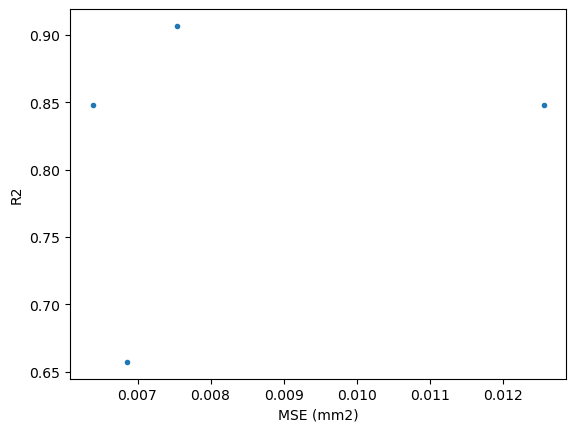

In [19]:
plt.plot(np.array(best_scores)[:,0],np.array(best_scores)[:,1],'.')
plt.ylabel('R2')
plt.xlabel('MSE (mm2)')
plt.savefig('F:/usda/work/CookIRCamET/Documents/et_errors.png',dpi=300)


In [62]:
pd.DataFrame(np.array(best_scores))

,0,1,2,3,4
0,0.006860,0.657303,1.0,935.0,12981.0
1,0.006388,0.848173,2.0,3681.0,6490.0
2,0.007546,0.906522,3.0,8172.0,4327.0
3,0.012562,0.847552,4.0,14489.0,3245.0


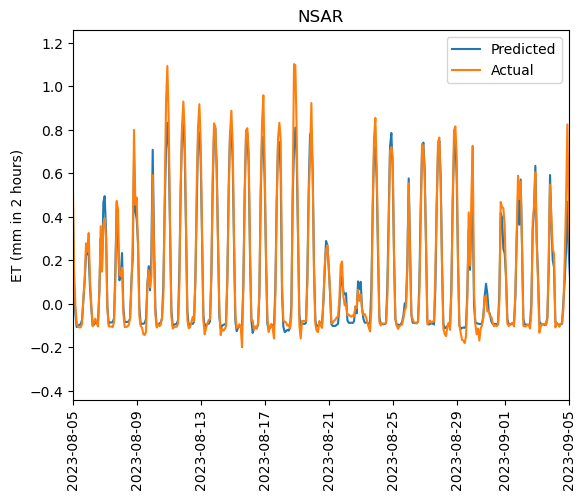

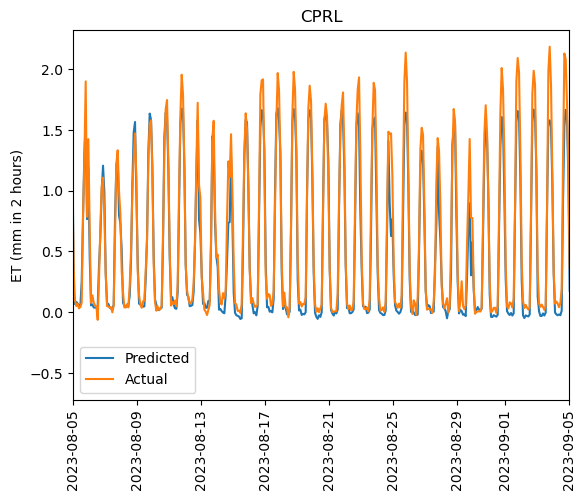

In [69]:
for daily_flux,location in zip([daily_flux_cook,daily_flux_cprl],['NSAR','CPRL']):
    times = pd.to_datetime(daily_flux['times'].values.reshape([-1,period_length])[:,1])
    batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
    batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
    all_et = np.sum(batched_et,axis=1)
    period_length=2
    batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
    all_feats = batched_flux[:,0:period_length*n_feats]
    with open(os.path.join(p3,'et_mlp_pipeline_'+str(period_length)+'_final.pk.sav'),'rb') as file:
        model = pickle.load(file)
        pred_et = model.predict(all_feats)
    fig, ax = plt.subplots()
    ax.plot(times,pred_et, label='Predicted')
    ax.plot(times,all_et, label='Actual')
    ax.set_title(location)
    ax.legend()
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('ET (mm in '+str(period_length)+' hours)')
    ax.set_xlim([pd.to_datetime('2023-8-5'),pd.to_datetime('2023-9-5')])
    plt.savefig('F:/usda/work/CookIRCamET/Documents/et_series_'+str(period_length)+'_'+location+'.png',dpi=300)
    plt.show()
    

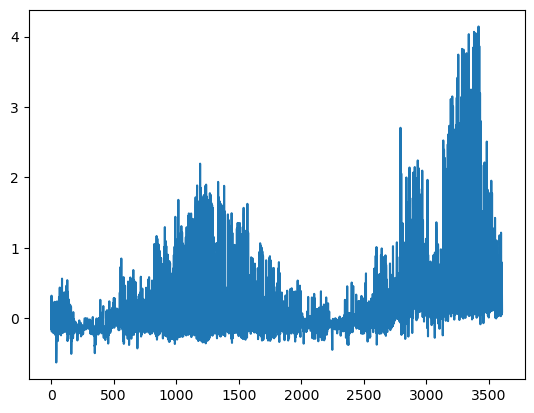